In [2]:
from __future__ import annotations
from dataclasses import dataclass
from typing import List, Optional, Dict, Any, Iterable
import hashlib
import tiktoken
from langchain_text_splitters import RecursiveCharacterTextSplitter
from FlagEmbedding import BGEM3FlagModel, FlagReranker
import numpy as np
import math
from typing import Sequence, Iterable

# Visual & Data libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import ipywidgets as widgets
from IPython.display import display, clear_output

# Configuration
pd.set_option('display.max_colwidth', 100)
sns.set_theme(style="whitegrid")

# Dataclasses

In [3]:
@dataclass
class Chunk:
    id: str
    text: str
    metadata: Dict[str, Any]
    

# Utilities

In [4]:
def _stable_chunk_id(source_id: str, chunk_index: int, text: str) -> str:
    h = hashlib.sha256(text.encode("utf-8")).hexdigest()[:16]
    return f"{source_id}:{chunk_index}:{h}"

def load_documents() -> List[Dict[str, Any]]:
    return [
        {
            "source_id": "policy_returns_tr",
            "title": "İade Politikası",
            "url": "https://example.com/iade",
            "text": (
                "İade politikamız aşağıdaki gibidir.\n\n"
                "1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. "
                "Ürün kullanılmamış olmalıdır.\n\n"
                "2) Kargo takip numarası sipariş sayfasında yer alır. "
                "İade kargo bedeli kampanya dönemlerinde ücretsiz olabilir.\n\n"
                "3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir.\n"
            ),
        },
        {
            "source_id": "policy_privacy_tr",
            "title": "Gizlilik Politikası",
            "url": "https://example.com/gizlilik",
            "text": (
                "Gizlilik politikamız aşağıdaki gibidir.\n\n"
                "1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir.\n\n"
                "2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz.\n\n"
                "3) Çerezler (cookies), deneyimi iyileştirmek ve analiz yapmak için kullanılabilir. "
                "Tarayıcı ayarlarınızdan çerezleri yönetebilirsiniz.\n\n"
                "4) Veri saklama süresi, ilgili mevzuata uygun şekilde belirlenir; gerekli olmadığında veriler silinir veya anonimleştirilir.\n"
            )
        }
    ]

def print_chunk_stats(chunks: List[Chunk], top_n: int = 5) -> None:
    if not chunks:
        print("No chunks.")
        return

    token_counts = [c.metadata["token_count"] for c in chunks]
    print(f"chunks: {len(chunks)}")
    print(f"min/avg/max tokens: {min(token_counts)} / {sum(token_counts)/len(token_counts):.1f} / {max(token_counts)}")

    # En uzun birkaç chunk'a bak (önizleme)
    longest = sorted(chunks, key=lambda c: c.metadata["token_count"], reverse=True)[:top_n]
    print("\nLongest chunks:")
    for c in longest:
        preview = c.text[:160].replace("\n", " ")
        print(f"- {c.id} | {c.metadata['token_count']} tok | {preview}...")

def sigmoid(x):
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))

# Chunking

In [18]:
def build_text_splitter(
        *,
        encoding_name: str = "o200k_base",
        chunk_size: int = 600,   # token cinsinden hedef
        chunk_overlap: int = 80, # token cinsinden overlap
) -> tuple[RecursiveCharacterTextSplitter, Any]:
    enc = tiktoken.get_encoding(encoding_name)

    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name=encoding_name,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=[
            "\n\n",         # paragraf
            "\n",           # satır
            ". ",           # cümle
            "? ",
            "! ",
            "; ",
            ": ",
            ", ",
            " ",
            ""              # last resort: karakter bazlı
        ],
        add_start_index=True,
    )

    return splitter, enc


def chunk_documents(
        docs: Iterable[Dict[str, Any]],
        *,
        encoding_name: str = "o200k_base",
        chunk_size: int = 600,
        chunk_overlap: int = 80,
        text_key: str = "text",
        source_id_key: str = "source_id",
) -> List[Chunk]:
    """
    docs input örneği:
      {"source_id": "policy_001", "text": "...", "title": "...", "url": "..."}
    """
    splitter, enc = build_text_splitter(
        encoding_name=encoding_name,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    out: List[Chunk] = []

    for doc in docs:
        source_id = str(doc.get(source_id_key) or doc.get("id") or "unknown")
        text = str(doc.get(text_key) or "")

        pieces = splitter.create_documents([text], metadatas=[{k: v for k, v in doc.items() if k != text_key}])
        for i, p in enumerate(pieces):
            chunk_text = p.page_content.strip()
            if not chunk_text:
                continue

            token_count = len(enc.encode(chunk_text))
            md = dict(p.metadata or {})
            md.update({
                "source_id": source_id,
                "chunk_index": i,
                "token_count": token_count,
            })

            chunk_id = _stable_chunk_id(source_id, i, chunk_text)
            out.append(Chunk(id=chunk_id, text=chunk_text, metadata=md))
    return out

In [6]:
sample_docs = load_documents()
chunks = chunk_documents(
    sample_docs,
    encoding_name="o200k_base", # 200k için optimize edilmiş tokenizer
    chunk_size=30,       # demo için küçük
    chunk_overlap=3,
)

print_chunk_stats(chunks)

chunks: 11
min/avg/max tokens: 9 / 19.8 / 29

Longest chunks:
- policy_returns_tr:2:4071d5867bcd5a10 | 29 tok | 2) Kargo takip numarası sipariş sayfasında yer alır. İade kargo bedeli kampanya dönemlerinde ücretsiz olabilir....
- policy_privacy_tr:2:00de60f5b8c61801 | 29 tok | 2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz....
- policy_returns_tr:1:e7c0352d38efe0e9 | 28 tok | 1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. Ürün kullanılmamış olmalıdır....
- policy_privacy_tr:1:455df706c869ad96 | 24 tok | 1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir....
- policy_returns_tr:3:86e05d8b3137f8c4 | 23 tok | 3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir....


# Embedding

In [7]:
model = BGEM3FlagModel("BAAI/bge-m3", use_fp16=True) # GPU varsa fp16 kullan
docs = [c.text for c in chunks]
doc_out = model.encode(
    docs,
    batch_size=32,
    max_length=1024,
    return_dense=True,
    return_sparse=False,
    return_colbert_vecs=False
)

doc_vecs = doc_out["dense_vecs"] # (N, 1024)
# Show first few vectors partially
for i in range(min(5, len(docs))):
    print(f"Doc {i} vec shape: {doc_vecs[i].shape}, First 5 dim: {doc_vecs[i][:5]}")

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Doc 0 vec shape: (1024,), First 5 dim: [-0.0392    0.002842 -0.03415   0.02911  -0.03967 ]
Doc 1 vec shape: (1024,), First 5 dim: [-0.01823  0.03674 -0.02942  0.03036 -0.03278]
Doc 2 vec shape: (1024,), First 5 dim: [-0.06033 -0.0399  -0.0442   0.00414 -0.00745]
Doc 3 vec shape: (1024,), First 5 dim: [-0.00829   0.01214  -0.04337   0.015114 -0.02368 ]
Doc 4 vec shape: (1024,), First 5 dim: [-0.05148 -0.01794 -0.02896  0.01491 -0.02986]


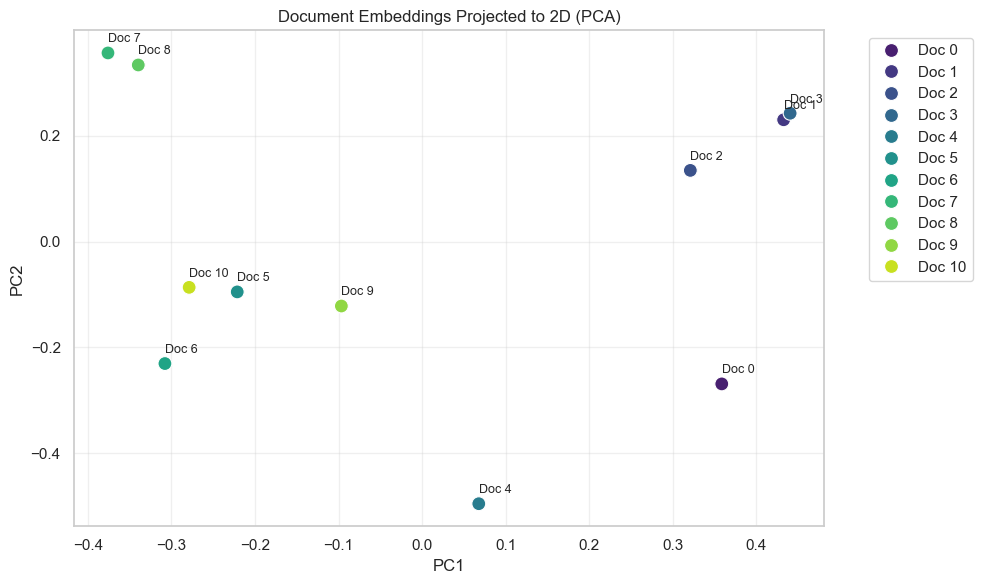

In [8]:
# Visualize Embedding Space (PCA)
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(doc_vecs)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=vecs_2d[:, 0], y=vecs_2d[:, 1], s=100, hue=[f"Doc {i}" for i in range(len(docs))], palette="viridis")

# Annotate points
for i, txt in enumerate(docs):
    plt.annotate(f"Doc {i}", (vecs_2d[i, 0], vecs_2d[i, 1]+0.02), fontsize=9)

plt.title("Document Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Similarities

In [9]:
def dot(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b))


def l2_norm(a: np.ndarray) -> float:
    return float(np.linalg.norm(a))


def cosine_similarity(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    denom = max(l2_norm(a) * l2_norm(b), eps)
    return dot(a, b) / denom


def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))


def l2_normalize(a: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(a)
    return a / max(n, eps)

# Similarity Search Hands on

## Cosine Similarity [-1,1] aralığında, 1'e ne kadar yakın o kadar benzer

## Euclidean Distance [0, ∞) aralığında, 0'a ne kadar yakın o kadar benzer

## Dot Product [−∞, ∞) aralığında, büyük değerler daha benzer

# Yöntem

- Soruyu embedding ile vektöre çevir
- Vector databaseindeki tüm vectorler ile Cosine, Euclidean ve Dot Product karşılaştır
- Yukarıdaki şartlarda benzerlikleri bul.

## Training: Farklı chunk sizelar ile aynı işlemleri dene

In [10]:
question = "Ücret iade süreci nedir?"

In [11]:

question_vector = model.encode(
    [question],
    batch_size=1,
    max_length=1024,
    return_dense=True,
    return_sparse=False,
    return_colbert_vecs=False,
)["dense_vecs"][0]  # (1024,)

# Calculate metrics for all documents
results = []
for i in range(len(docs)):
    cosine = cosine_similarity(question_vector, doc_vecs[i])
    euclidean = euclidean_distance(question_vector, doc_vecs[i])
    dot_product = dot(question_vector, doc_vecs[i])
    
    results.append({
        "Doc Index": f"Doc {i}",
        "Text Preview": docs[i], 
        "Cosine Sim": cosine,
        "Euclidean Dist": euclidean,
        "Dot Product": dot_product
    })

# Create DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Cosine Sim", ascending=False).reset_index(drop=True)

# Display using Pandas (clean table)
print(f"Question: {question}\n")
display(df_results[["Doc Index", "Cosine Sim", "Euclidean Dist", "Dot Product", "Text Preview"]])

Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00, 47.56it/s]

Question: Ücret iade süreci nedir?



,Doc Index,Cosine Sim,Euclidean Dist,Dot Product,Text Preview
0,Doc 3,0.657059,0.828613,0.656738,3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir.
1,Doc 1,0.624328,0.867188,0.624023,1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. Ürün kullanılmamış...
2,Doc 0,0.592375,0.903320,0.591797,İade politikamız aşağıdaki gibidir.
3,Doc 2,0.527370,0.972168,0.526855,2) Kargo takip numarası sipariş sayfasında yer alır. İade kargo bedeli kampanya dönemlerinde ücr...
4,Doc 5,0.402981,1.092773,0.402588,"1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir."
5,Doc 9,0.396434,1.098633,0.396240,"4) Veri saklama süresi, ilgili mevzuata uygun şekilde belirlenir"
6,Doc 10,0.396190,1.098633,0.395996,; gerekli olmadığında veriler silinir veya anonimleştirilir.
7,Doc 4,0.363214,1.128906,0.363037,Gizlilik politikamız aşağıdaki gibidir.
8,Doc 6,0.347582,1.142578,0.347412,"2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz."
9,Doc 7,0.340743,1.148438,0.340576,"3) Çerezler (cookies), deneyimi iyileştirmek ve analiz yapmak için kullanılabilir"


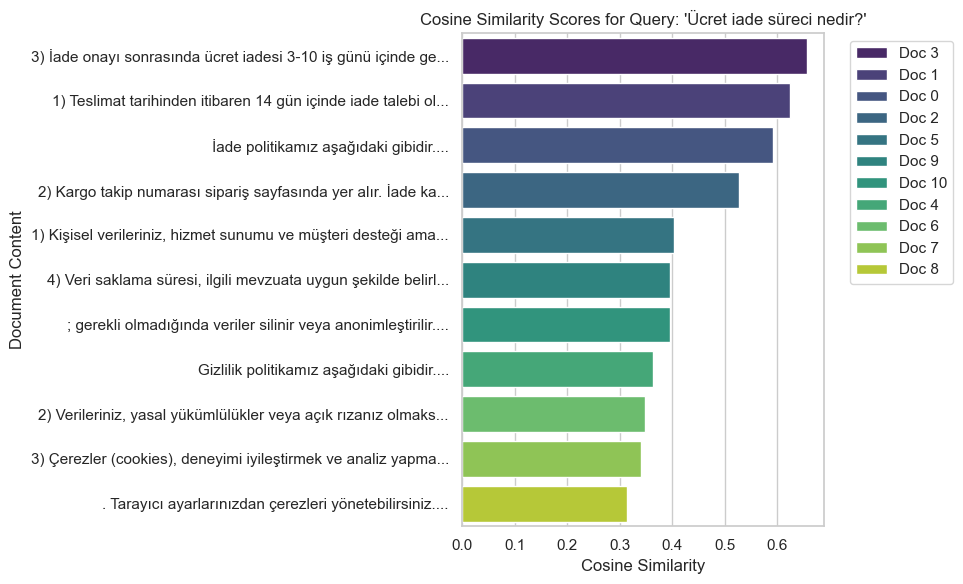

In [12]:
# Visualization of Similarity Scores
plt.figure(figsize=(10, 6))

# Truncate text for plotting
df_results['Truncated Text'] = df_results['Text Preview'].apply(lambda x: x[:60] + '...')

sns.barplot(data=df_results, x="Cosine Sim", y="Truncated Text", hue="Doc Index", palette="viridis", dodge=False)
plt.title(f"Cosine Similarity Scores for Query: '{question}'")
plt.xlabel("Cosine Similarity")
plt.ylabel("Document Content")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Reranking

In [13]:
reranker_model = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

candidates = [d for d in docs]
rerank_pairs = [[question, doc] for doc in candidates]

# Compute scores
rerank_scores_logits = reranker_model.compute_score(rerank_pairs)
rerank_scores_probs = sigmoid(rerank_scores_logits)

# Create DataFrame for results
rerank_results = []
for i, (doc, score) in enumerate(zip(candidates, rerank_scores_probs)):
    rerank_results.append({
        "Original Index": i,
        "Document": doc,
        "Rerank Score": score
    })

df_rerank = pd.DataFrame(rerank_results)
df_rerank = df_rerank.sort_values(by="Rerank Score", ascending=False).reset_index(drop=True)

print("After Reranking:")
display(df_rerank)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


After Reranking:


,Original Index,Document,Rerank Score
0,3,3) İade onayı sonrasında ücret iadesi 3-10 iş günü içinde gerçekleştirilir.,0.390069
1,1,1) Teslimat tarihinden itibaren 14 gün içinde iade talebi oluşturabilirsiniz. Ürün kullanılmamış...,0.027221
2,0,İade politikamız aşağıdaki gibidir.,0.020804
3,2,2) Kargo takip numarası sipariş sayfasında yer alır. İade kargo bedeli kampanya dönemlerinde ücr...,0.001642
4,10,; gerekli olmadığında veriler silinir veya anonimleştirilir.,0.000068
5,9,"4) Veri saklama süresi, ilgili mevzuata uygun şekilde belirlenir",0.000048
6,5,"1) Kişisel verileriniz, hizmet sunumu ve müşteri desteği amaçlarıyla işlenir.",0.000047
7,6,"2) Verileriniz, yasal yükümlülükler veya açık rızanız olmaksızın üçüncü taraflarla paylaşılmaz.",0.000037
8,4,Gizlilik politikamız aşağıdaki gibidir.,0.000017
9,8,. Tarayıcı ayarlarınızdan çerezleri yönetebilirsiniz.,0.000016


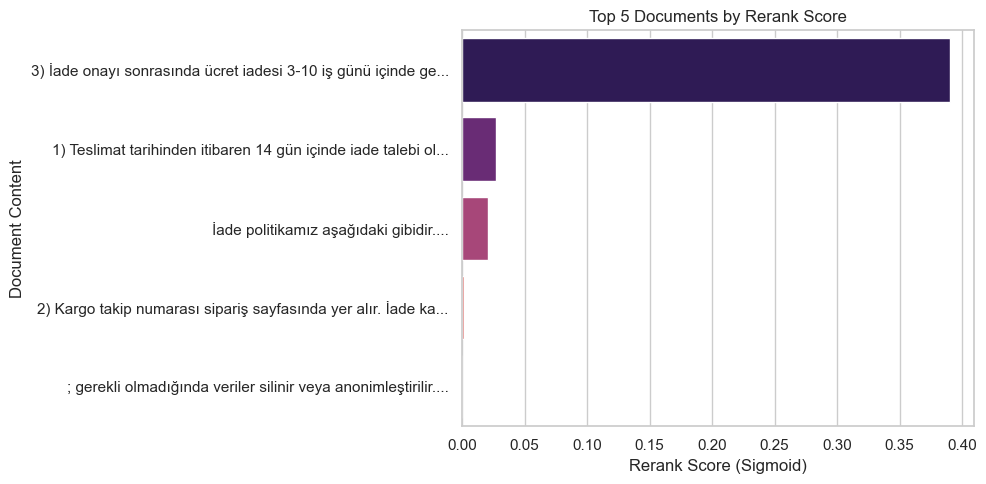

In [14]:
# Compare Top 5 Rerank Scores
plt.figure(figsize=(10, 5))

# Truncate text for plotting
df_top5 = df_rerank.head(5).copy()
df_top5['Truncated Document'] = df_top5['Document'].apply(lambda x: x[:60] + '...')

sns.barplot(data=df_top5, x="Rerank Score", y="Truncated Document", hue="Truncated Document", palette="magma", legend=False)
plt.title("Top 5 Documents by Rerank Score")
plt.xlabel("Rerank Score (Sigmoid)")
plt.ylabel("Document Content")

plt.tight_layout()
plt.show()

# Değerlendirme

- Recall@k
- MRR
- nDCG

In [15]:
def recall_at_k(relevant: set, ranked_list: Sequence, k: int) -> float:
    if k <= 0:
        return 0.0
    hits = sum(1 for item in ranked_list[:k] if item in relevant)
    return hits / max(1, len(relevant))

def mean_reciprocal_rank(list_of_ranked: Iterable[Sequence], list_of_relevant: Iterable[set]) -> float:
    total, n = 0.0, 0
    for ranked, rel in zip(list_of_ranked, list_of_relevant):
        rr = 0.0
        for idx, item in enumerate(ranked, 1):
            if item in rel:
                rr = 1.0 / idx
                break
        total += rr
        n += 1
    return total / max(1, n)

def ndcg(ranked_list: Sequence, relevance: dict, k: int) -> float:
    def dcg(items):
        return sum((2 ** relevance.get(item, 0) - 1) / math.log2(i + 2) for i, item in enumerate(items[:k]))
    ideal = dcg(sorted(ranked_list, key=lambda x: relevance.get(x, 0), reverse=True))
    if ideal == 0:
        return 0.0
    return dcg(ranked_list) / ideal

In [16]:
relevant_chunks = set(chunk_index for chunk_index, chunk in enumerate(chunks) if chunk.metadata.get("source_id") == "policy_returns_tr")

print(f"Relevant chunk indices: {relevant_chunks}")
print(f"Total relevant chunks: {len(relevant_chunks)}")

# Use the reranked list for evaluation
ranked_indices = []
for doc in df_rerank["Document"].values:
    # Find index in original chunks list
    for i, chunk in enumerate(chunks):
        if chunk.text == doc:
            ranked_indices.append(i)
            break

print(f"\nRanked indices (after rerank): {ranked_indices}")

# Recall@k
metrics_data = []
for k in [3, 5]:
    recall = recall_at_k(relevant_chunks, ranked_indices, k)
    metrics_data.append({"Metric": f"Recall@{k}", "Value": recall})

# MRR
mrr = mean_reciprocal_rank([ranked_indices], [relevant_chunks])
metrics_data.append({"Metric": "MRR", "Value": mrr})

# nDCG
relevance_scores = {}
for i in range(len(chunks)):
    if i in relevant_chunks:
        relevance_scores[i] = 2
    else:
        relevance_scores[i] = 0

for k in [3, 5, len(ranked_indices)]:
    ndcg_score = ndcg(ranked_indices, relevance_scores, k)
    metrics_data.append({"Metric": f"nDCG@{k}", "Value": ndcg_score})

# Show Metrics Table
pd.DataFrame(metrics_data)

Relevant chunk indices: {0, 1, 2, 3}
Total relevant chunks: 4

Ranked indices (after rerank): [3, 1, 0, 2, 10, 9, 5, 6, 4, 8, 7]


,Metric,Value
0,Recall@3,0.75
1,Recall@5,1.00
2,MRR,1.00
3,nDCG@3,1.00
4,nDCG@5,1.00
5,nDCG@11,1.00


# Hands on!

## Başka sorular için tüm hesapları yapıp, metrik yorumlayalım.

In [ ]:
# Interactive Search Widget
query_input = widgets.Text(
    value='Ücret iadesi ne zaman yapılır?',
    placeholder='Sorunuzu buraya yazın...',
    description='Soru:',
    layout=widgets.Layout(width='80%')
)
button = widgets.Button(description="Ara", button_style='primary')
output_area = widgets.Output()

def on_search_clicked(b):
    with output_area:
        clear_output()
        question = query_input.value
        print(f"Searching for: {question}...")
        
        # 1. Embed Question
        q_vec = model.encode([question], return_dense=True)["dense_vecs"][0]
        
        # 2. Rerank Candidates
        candidates = [d for d in docs]
        pairs = [[question, d] for d in candidates]
        scores = sigmoid(reranker_model.compute_score(pairs))
        
        # 3. Create DataFrame
        res = []
        for i, (doc, score) in enumerate(zip(candidates, scores)):
            res.append({"Score": score, "Document": doc})
        
        df_res = pd.DataFrame(res).sort_values("Score", ascending=False).head(5)
        
        # 4. Display Results
        display(df_res.style.bar(subset=['Score'], color='#5fba7d', vmin=0, vmax=1))
        
        # 5. Visualize in 2D (Optional: Project Question too)
        # Note: Re-running PCA for every query is not ideal for large datasets, strictly for demo here.
        all_vecs = np.vstack([doc_vecs, q_vec])
        pca_rt = PCA(n_components=2)
        vecs_2d_rt = pca_rt.fit_transform(all_vecs)
        
        plt.figure(figsize=(8, 5))
        # Docs
        sns.scatterplot(x=vecs_2d_rt[:-1, 0], y=vecs_2d_rt[:-1, 1], s=80, alpha=0.6, color='blue', label='Docs')
        # Question
        sns.scatterplot(x=[vecs_2d_rt[-1, 0]], y=[vecs_2d_rt[-1, 1]], s=200, marker='X', color='red', label='Question')
        
        for i, txt in enumerate(docs):
             if scores[i] > 0.1: # Only label relevant ones to reduce clutter
                plt.annotate(f"Doc {i}", (vecs_2d_rt[i, 0], vecs_2d_rt[i, 1]))
        
        plt.title("Query Position in Semantic Space")
        plt.legend()
        plt.show()

button.on_click(on_search_clicked)
display(widgets.VBox([query_input, button, output_area]))